In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
import sys
#sys.path.insert(0, './../')
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
%pip install psds_eval
import bbdc2021 as bbdc

Mounted at /content/drive
     |████████████████████████████████| 286kB 10.1MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4


In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Mar 29 12:52:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.4 gigabytes of available RAM

You are using a high-RAM runtime!


In [5]:
pipe_param = {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

In [6]:
def pipeline_u_net_1(pipe_param, model_param):
    """Current u_net pipeline from loading data to prediction.
    Takes paramater dictionary as argument"""
    print('Pipeline parameter:', pipe_param)
    print('Model parameter:', model_param)
    # load
    x_dev, y_dev, timep, filelist_dev, x_ch, filelist_ch = bbdc.loading_block1(pipe_param)
    #n_files_colab = 5000
    #x_dev, y_dev, filelist_dev = x_dev[:n_files_colab], y_dev[:n_files_colab], filelist_dev[:n_files_colab]
    # split (tv=train and val set)
    x_tv, x_test, y_tv, y_test, filelist_test = bbdc.split_block1(x_dev, y_dev, timep, filelist_dev, pipe_param)
    # model fit (or load)
    history, model = bbdc.model_block1_unet(x_tv, y_tv, unet_param)
    # evaluate
    scores_list, model_psds = bbdc.evaluation_block1(x_test, y_test, timep, filelist_test, model, pipe_param)
    # post processing and its evaluation
    pp_pred_test, pp_pred_ch, pp_psds = bbdc.postprocessing_with_evaluation_block1(x_test, y_test, timep,
                                                                                   filelist_test, x_ch,
                                                                                   filelist_ch, model, pipe_param)
    # challenge prediction
    bbdc.challenge_prediction_block1(pp_pred_ch, timep, filelist_ch, pipe_param)
    return scores_list, model_psds, pp_psds

In [7]:
def cross_val(pipeline, pipeparam, modelparam, testindexlist):
    """Cross validates a given pipepline."""
    all_scores_list = []
    all_model_psds = []
    all_pp_psds = []
    for indices in testindexlist:
        pipe_param['test_split_range'] = indices
        print('Test Split:', indices)
        scores_list, model_psds, pp_psds = pipeline(pipeparam, modelparam)
        all_scores_list.append(scores_list)
        all_model_psds.append(model_psds)
        all_pp_psds.append(pp_psds)
        print('\n\n\n')
    fold = len(test_index_list)
    print('Cross validation summary:')
    print('Loss ', [elem[0] for elem in all_scores_list])
    print('Mean Loss', sum([elem[0] for elem in all_scores_list])/fold)
    print('')
    print('MAE', [elem[1] for elem in all_scores_list])
    print('Mean MAE', sum([elem[1] for elem in all_scores_list])/fold)
    print('')
    print('Accuracy', [elem[2] for elem in all_scores_list])
    print('Mean Accuracy', sum([elem[2] for elem in all_scores_list])/fold)
    print('')
    print('Model PSDS', all_model_psds)
    print('Mean model PSDS', sum(all_model_psds)/fold)
    print('')
    print('Post processed PSDS', all_pp_psds)
    print('Mean Post processed PSDS', sum(all_pp_psds)/fold)

Test Split: (0, 1000)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (0, 1000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 0 to 1000 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
5

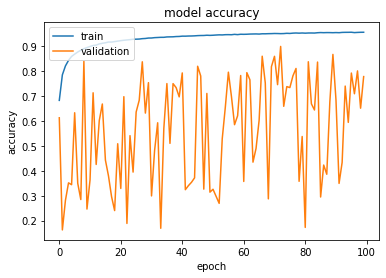

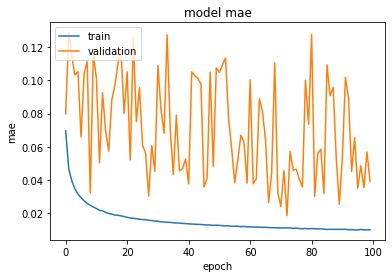

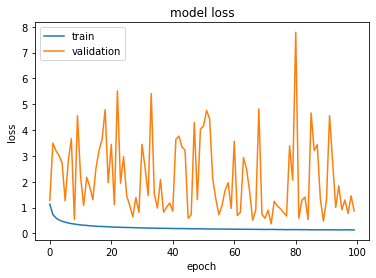

32/32 [==============================] - 0s 8ms/step - loss: 0.8948 - mae: 0.0395 - accuracy: 0.7791

Evaluation:
Loss, MAE, Accuracy [0.8948414325714111, 0.03947063535451889, 0.779115617275238]
PSDS (0.0484450742240216, 'Valid file')

Filling post processing used.
PSDS (0.42180055251551607, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (1000, 2000)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (1000, 2000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 1000 to 2000 from dev set.
E

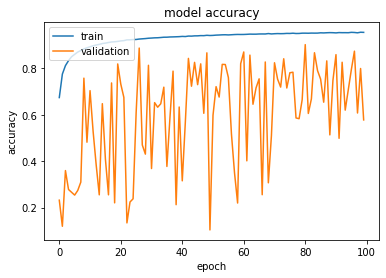

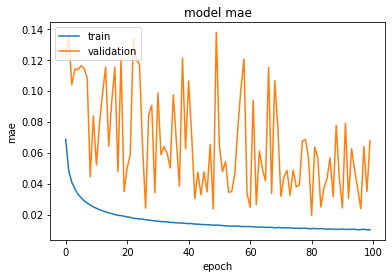

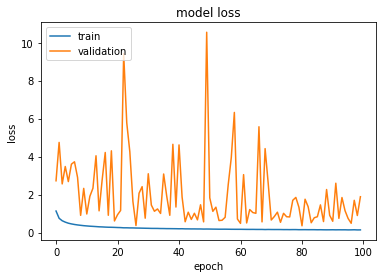

32/32 [==============================] - 0s 8ms/step - loss: 1.9702 - mae: 0.0694 - accuracy: 0.5660

Evaluation:
Loss, MAE, Accuracy [1.9701611995697021, 0.06937456130981445, 0.5660187602043152]
PSDS (0.07982802479533366, 'Valid file')

Filling post processing used.
PSDS (0.40558823181598824, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (2000, 3000)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (2000, 3000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 2000 to 3000 from dev set.
E

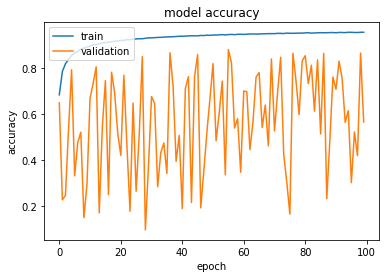

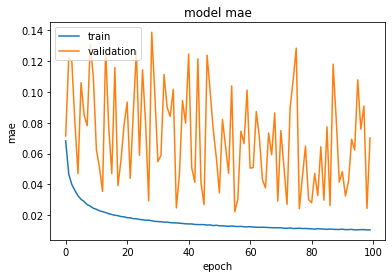

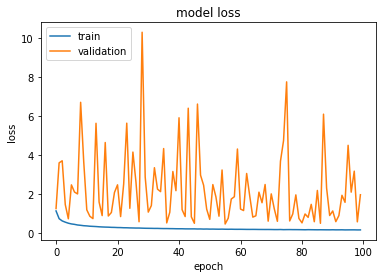

32/32 [==============================] - 0s 8ms/step - loss: 1.9263 - mae: 0.0702 - accuracy: 0.5654

Evaluation:
Loss, MAE, Accuracy [1.9263098239898682, 0.07019106298685074, 0.5654125213623047]
PSDS (0.13197943770708026, 'Valid file')

Filling post processing used.
PSDS (0.3695652872332456, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (3000, 4000)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (3000, 4000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 3000 to 4000 from dev set.
E

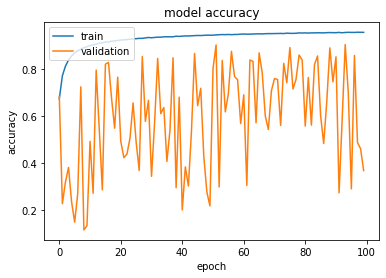

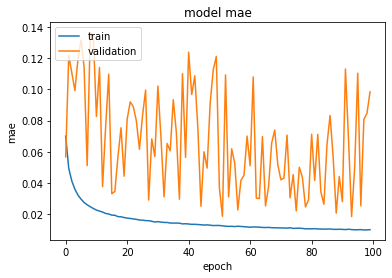

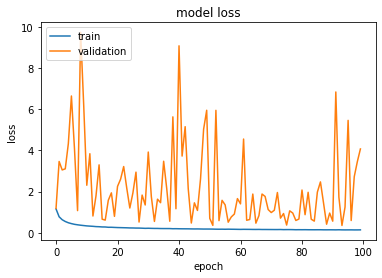

32/32 [==============================] - 0s 8ms/step - loss: 4.0996 - mae: 0.0981 - accuracy: 0.3682

Evaluation:
Loss, MAE, Accuracy [4.0996198654174805, 0.09811241179704666, 0.36822187900543213]
PSDS (0.04098013086491708, 'Valid file')

Filling post processing used.
PSDS (0.26820760729972243, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (4000, 5000)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (4000, 5000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 4000 to 5000 from dev set.
E

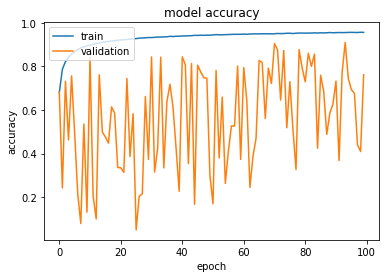

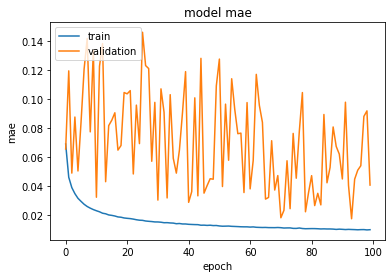

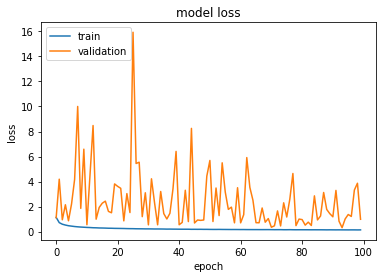

32/32 [==============================] - 0s 8ms/step - loss: 1.0014 - mae: 0.0409 - accuracy: 0.7612

Evaluation:
Loss, MAE, Accuracy [1.0013628005981445, 0.040907349437475204, 0.7612000107765198]
PSDS (0.08376672874449373, 'Valid file')

Filling post processing used.
PSDS (0.4443235814081422, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (5000, 6000)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (5000, 6000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 5000 to 6000 from dev set.
E

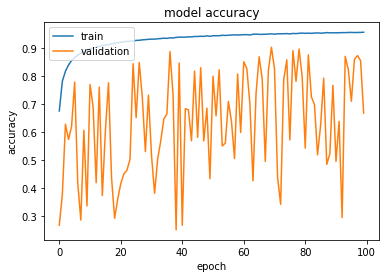

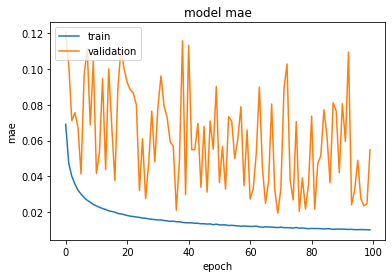

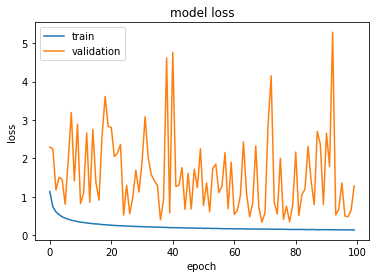

32/32 [==============================] - 0s 8ms/step - loss: 1.3675 - mae: 0.0578 - accuracy: 0.6471

Evaluation:
Loss, MAE, Accuracy [1.3674898147583008, 0.05782032012939453, 0.6471124887466431]
PSDS (0.04861988726068544, 'Valid file')

Filling post processing used.
PSDS (0.35286847909460767, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (6000, 7000)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (6000, 7000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 6000 to 7000 from dev set.
E

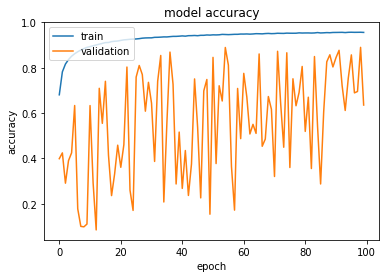

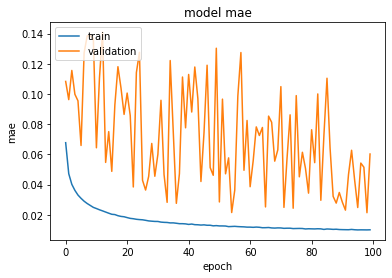

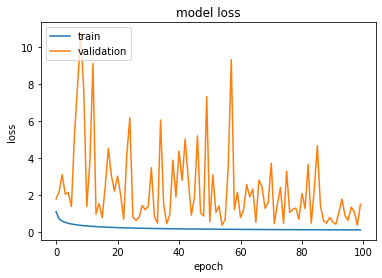

32/32 [==============================] - 0s 8ms/step - loss: 1.5696 - mae: 0.0619 - accuracy: 0.6243

Evaluation:
Loss, MAE, Accuracy [1.569555640220642, 0.06190204620361328, 0.6242906451225281]
PSDS (0.0346614523724695, 'Valid file')

Filling post processing used.
PSDS (0.2062770475967735, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (7000, 8000)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (7000, 8000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 7000 to 8000 from dev set.
E

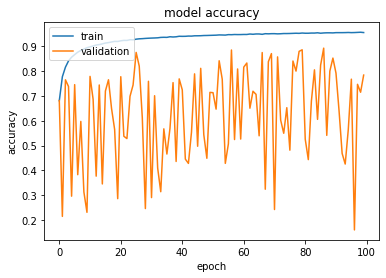

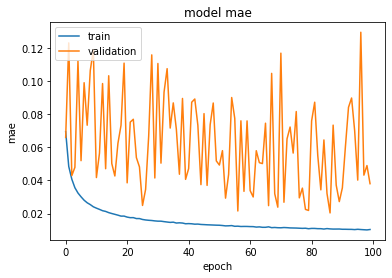

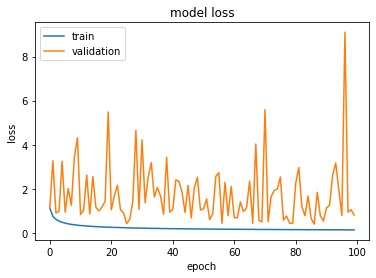

32/32 [==============================] - 0s 8ms/step - loss: 0.8450 - mae: 0.0391 - accuracy: 0.7755

Evaluation:
Loss, MAE, Accuracy [0.8450146317481995, 0.039137065410614014, 0.7754937410354614]
PSDS (0.04316028854259739, 'Valid file')

Filling post processing used.
PSDS (0.5882448491845959, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (8000, 9000)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (8000, 9000), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to 9000 from dev set.
E

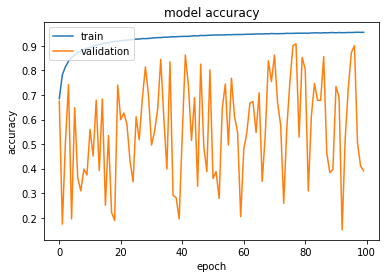

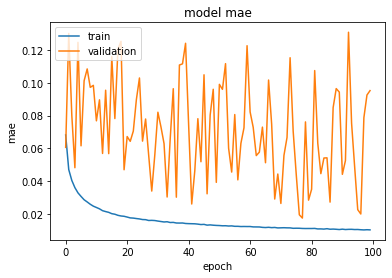

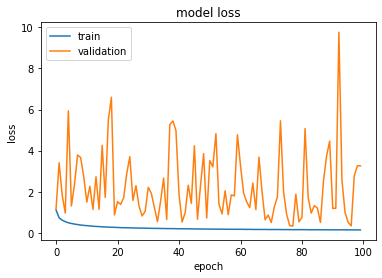

32/32 [==============================] - 0s 8ms/step - loss: 3.2111 - mae: 0.0953 - accuracy: 0.3903

Evaluation:
Loss, MAE, Accuracy [3.2111146450042725, 0.09533765912055969, 0.39025312662124634]
PSDS (0.04727440363885885, 'Valid file')

Filling post processing used.
PSDS (0.17077888998069937, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Test Split: (9000, -1)
Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (9000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Existin

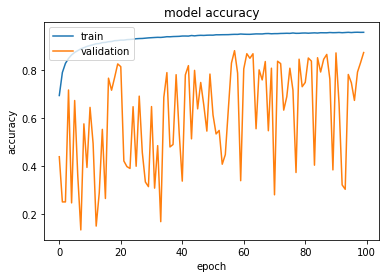

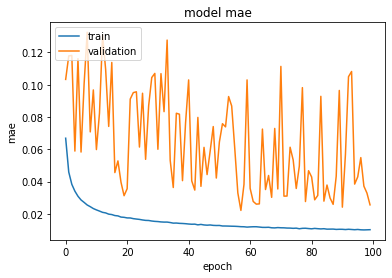

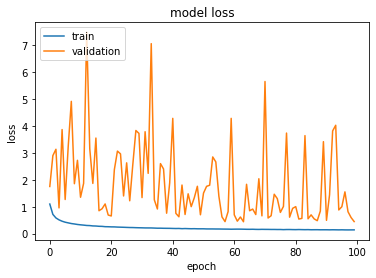

32/32 [==============================] - 0s 8ms/step - loss: 0.4462 - mae: 0.0256 - accuracy: 0.8719

Evaluation:
Loss, MAE, Accuracy [0.4462040066719055, 0.02557285502552986, 0.8719406723976135]
PSDS (0.11281566754600503, 'Valid file')

Filling post processing used.
PSDS (0.6797413142260404, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv




Cross validation summary:
Loss  [0.8948414325714111, 1.9701611995697021, 1.9263098239898682, 4.0996198654174805, 1.0013628005981445, 1.3674898147583008, 1.569555640220642, 0.8450146317481995, 3.2111146450042725, 0.4462040066719055]
Mean Loss 1.7331673860549928

MAE [0.03947063535451889, 0.06937456130981445, 0.07019106298685074, 0.09811241179704666, 0.040907349437475204, 0.05782032012939453, 0.06190204620361328, 0.039137065410614014, 0.09533765912055969, 0.02557285502552986]
Mean MAE 0.05978259667754173

Accuracy [0.779115617275238, 0.5660187602043152, 0.5654125213623047, 0.36822187900543213, 0.7612000107765198, 0.6471124887466431, 0.6242906451225281, 0.7754937410354614, 0.39025312662124634, 0.8719406723976135]
Mean Accuracy 0.6349059462547302

Model PSDS [0.0484450742240216, 0.07982802479533366, 0.13197943770708026, 0.04098013086491708, 0.08376672874449373, 0.04861988726068544, 0.0346614523724695, 0.04316028854259739, 0.0472744036

In [ ]:
# cross validation mit submission1 parameter (submission ergab 0.23)
pipe_param = {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

test_index_list = [(0, 1000), (1000, 2000), (2000, 3000), (3000, 4000), (4000, 5000),
                   (5000, 6000), (6000, 7000), (7000, 8000), (8000, 9000), (9000, -1)]
cross_val(pipeline_u_net_1, pipe_param, unet_param, test_index_list)

Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (9000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [8, 16], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Tensorflow version: 2.4.1
Epoch 1/100
593/593 [==============================] - 26s 13ms/s

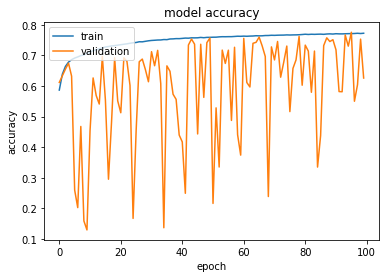

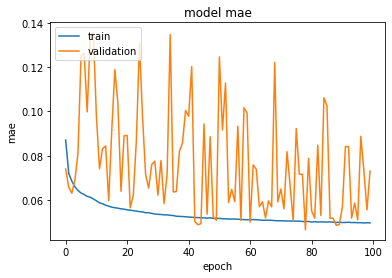

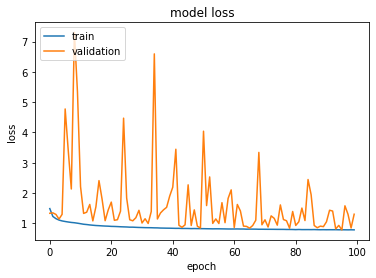

32/32 [==============================] - 0s 6ms/step - loss: 1.2927 - mae: 0.0729 - accuracy: 0.6270

Evaluation:
Loss, MAE, Accuracy [1.2927405834197998, 0.07288719713687897, 0.6269769668579102]
PSDS (0.027736480824716116, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 5 file(s) missing, e.g. ['09034_mix.wav', '09963_mix.wav', '09113_mix.wav']")


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([1.2927405834197998, 0.07288719713687897, 0.6269769668579102],
 0.027736480824716116,
 nan)

In [ ]:
# model regularizing
pipe_param = {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [8, 16],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (9000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 128, 256], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
593/593 [======

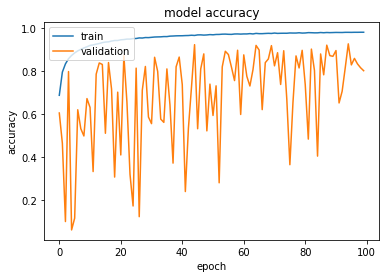

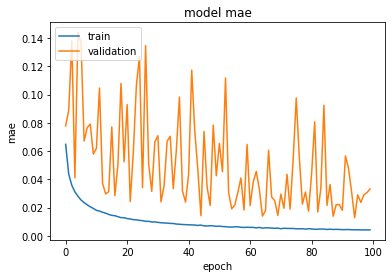

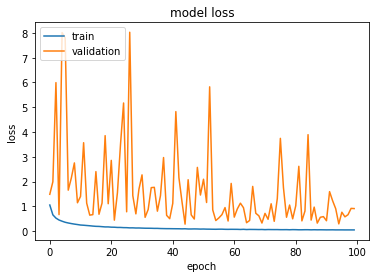

32/32 [==============================] - 0s 9ms/step - loss: 0.9167 - mae: 0.0331 - accuracy: 0.8024

Evaluation:
Loss, MAE, Accuracy [0.9167046546936035, 0.03312927484512329, 0.8023805022239685]
PSDS (0.21619981157557974, 'Valid file')

Filling post processing used.
PSDS (0.499415521046235, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([0.9167046546936035, 0.03312927484512329, 0.8023805022239685],
 0.21619981157557974,
 0.499415521046235)

In [ ]:
# model bigger
pipe_param = {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 128, 256],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (9000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 5, 'first_kernel_size': 5, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
593/593 [============

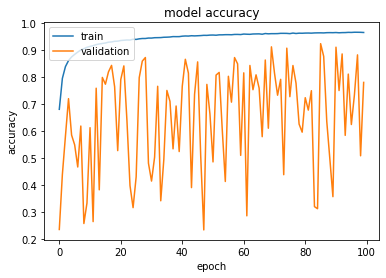

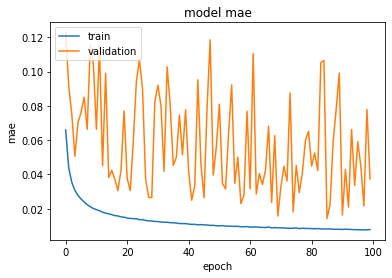

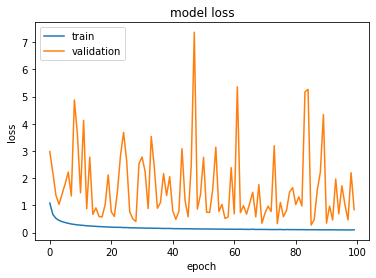

32/32 [==============================] - 0s 7ms/step - loss: 0.8463 - mae: 0.0373 - accuracy: 0.7813

Evaluation:
Loss, MAE, Accuracy [0.8462687730789185, 0.03728613629937172, 0.7813313603401184]
PSDS (0.12016432049605749, 'Valid file')

Filling post processing used.
PSDS (0.49416094009602374, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([0.8462687730789185, 0.03728613629937172, 0.7813313603401184],
 0.12016432049605749,
 0.49416094009602374)

In [ ]:
# kernel size
pipe_param = {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 5,
              'first_kernel_size': 5,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (9000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 7, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 15, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
593/593 [============

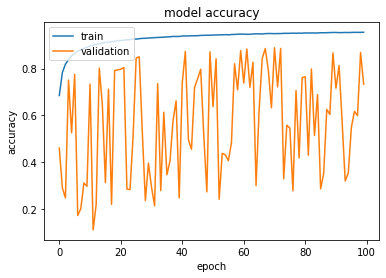

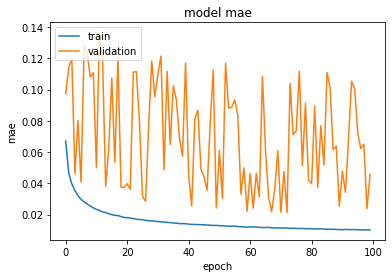

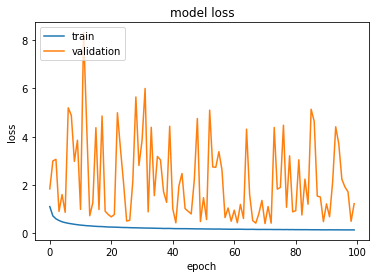

32/32 [==============================] - 0s 7ms/step - loss: 1.2242 - mae: 0.0460 - accuracy: 0.7308

Evaluation:
Loss, MAE, Accuracy [1.2242400646209717, 0.04600248113274574, 0.7307620048522949]
PSDS (0.03263118381539434, 'Valid file')

Filling post processing used.
PSDS (0.2691080479584873, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([1.2242400646209717, 0.04600248113274574, 0.7307620048522949],
 0.03263118381539434,
 0.2691080479584873)

In [ ]:
# first kernel size
pipe_param = {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 7,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 15,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (9000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 64], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.1111111111111111, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 100, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 9000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/100
18/18 [=============

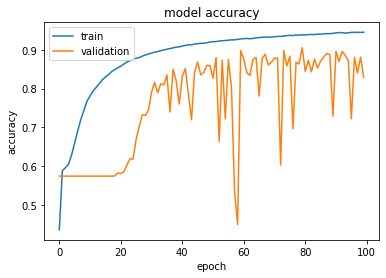

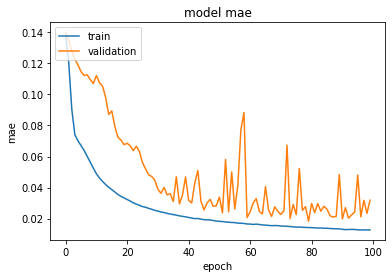

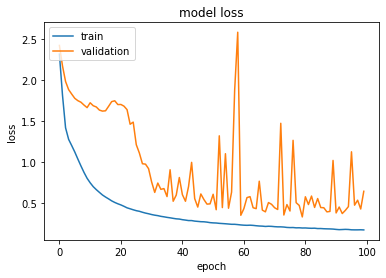

32/32 [==============================] - 0s 7ms/step - loss: 0.6451 - mae: 0.0315 - accuracy: 0.8313

Evaluation:
Loss, MAE, Accuracy [0.6451477408409119, 0.03154175728559494, 0.8313000798225403]
PSDS (0.07254163994230871, 'Valid file')

Filling post processing used.
PSDS (0.5804994346985092, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([0.6451477408409119, 0.03154175728559494, 0.8313000798225403],
 0.07254163994230871,
 0.5804994346985092)

In [ ]:
# batch size large
pipe_param = {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (9000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 64],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 1/9, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 100,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [8, 16], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 200, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Tensorflow version: 2.4.1
Epoch 1/200
16/16 [==============================] - 21s 171ms/step - loss: 2.5

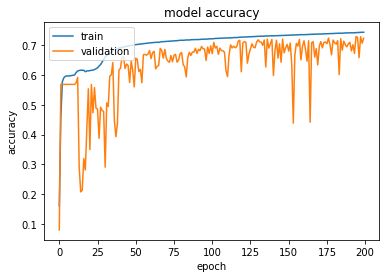

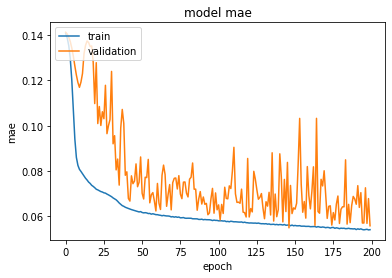

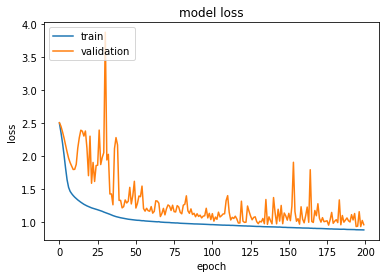

63/63 [==============================] - 0s 6ms/step - loss: 0.9545 - mae: 0.0559 - accuracy: 0.7236

Evaluation:
Loss, MAE, Accuracy [0.9545087218284607, 0.055877164006233215, 0.7236164808273315]
PSDS (0.030751299072959905, 'Valid file')

Filling post processing used.
PSDS (nan, "Each file needs to have at least one label. 32 file(s) missing, e.g. ['08827_mix.wav', '08846_mix.wav', '09963_mix.wav']")


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([0.9545087218284607, 0.055877164006233215, 0.7236164808273315],
 0.030751299072959905,
 nan)

In [9]:
# batch size large, 0.2 test split und val split, wenig channel, 200 epochs
pipe_param = {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [8, 16],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 200,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)

Pipeline parameter: {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/', 'wav_files_folder': 'final_pre_dataset', 'window_length': 1024, 'window_overlap': 523, 'band_size': 4, 'sample_rate': 16000, 'dev_csv': 'dev-labels.csv', 'eval_csv': 'challenge_filelist_dummy.csv', 'scaling': 'no', 'test_split_range': (8000, -1), 'prediction_path': './', 'post_processing': 'fill', 'submission_file_path': './challenge_submission.csv'}
Model parameter: {'channels': [32, 64, 128, 256], 'lessParameter': True, 'kernel_size': 3, 'first_kernel_size': 3, 'val_split_fraction': 0.2, 'loss': 'categorical_crossentropy', 'learning_rate': 0.001, 'batch_size': 512, 'epochs': 200, 'model_save_path': './', 'load_path': None}
Csv from wav files already existend. Skipping calc_fft.
Scaled numpy files already existend. Skipping scaling and load_data function.
Splitting test set at indices 8000 to -1 from dev set.
Existing model.h5 removed.
Tensorflow version: 2.4.1
Epoch 1/200
16/16 [======================

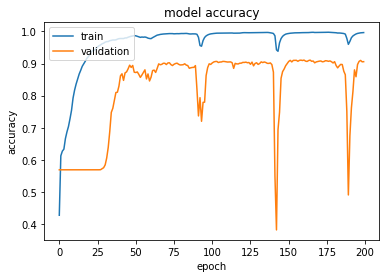

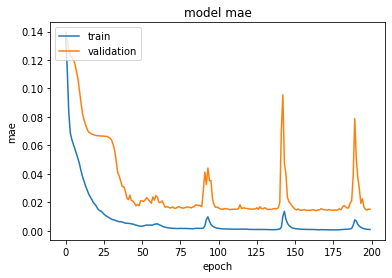

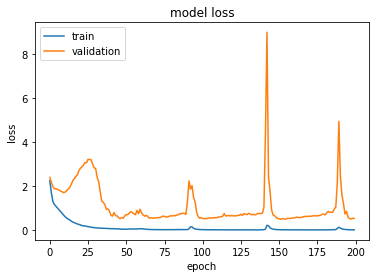

63/63 [==============================] - 1s 9ms/step - loss: 0.5327 - mae: 0.0152 - accuracy: 0.9059

Evaluation:
Loss, MAE, Accuracy [0.5327022075653076, 0.015204060822725296, 0.9058654308319092]
PSDS (0.2619910818873346, 'Valid file')

Filling post processing used.
PSDS (0.7335633440346864, 'Valid file')


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Submission file saved at ./challenge_submission.csv


([0.5327022075653076, 0.015204060822725296, 0.9058654308319092],
 0.2619910818873346,
 0.7335633440346864)

In [10]:
# batch size large, 0.2 test split und val split, mehr channel, 200 epochs
pipe_param = {'data_folder': '/content/drive/MyDrive/Colab Notebooks/data/',
                  'wav_files_folder': 'final_pre_dataset', # fft parameter
                  'window_length': 1024, 'window_overlap': 523,
                  'band_size': 4, 'sample_rate': 16000,
                  'dev_csv': 'dev-labels.csv', # filelisten, falls man doch auf kleinerem probieren moechte
                  'eval_csv': 'challenge_filelist_dummy.csv',
                  'scaling': 'no', # 'standard', 'minmax' oder 'no' wenn kein scaling sein soll
                  'test_split_range': (8000, -1), # index anfang und ende aus dev set 
                  'prediction_path': './', # wo prediction csvs gespeichert werden sollen
                  'post_processing': 'fill', # 'fill' is das von Jannes
                  'submission_file_path': './challenge_submission.csv'}
unet_param = {'channels': [32, 64, 128, 256],
              'lessParameter': True,
              'kernel_size': 3,
              'first_kernel_size': 3,
              'val_split_fraction': 0.2, # 1/9 damit man 1000 von den 9000 abzweigt
              'loss': 'categorical_crossentropy', # bbdc.dice_loss moeglich
              'learning_rate': 0.001,
              'batch_size': 512,
              'epochs': 200,
              'model_save_path': './',
              'load_path': None} # Wenn trainiert werden soll: None; Submission 1: 'model9561.h5'

pipeline_u_net_1(pipe_param, unet_param)